In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


num_cycles = 10000
num_samples = num_cycles
np.random.seed(42)

driving_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
charging_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
temperatures = np.random.normal(loc=25, scale=5, size=num_samples)

DoD = np.random.uniform(50, 100, size=num_samples) ### Depth of discharge (how much battery has been used)

trip_length = np.random.normal(loc=50, scale=20, size=num_samples)
cycles = np.arange(num_samples)

SoH = np.zeros(num_samples)
FCR = np.zeros(num_samples)

SoH[0] = 100.0
base_range = 500

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]
temp_effect = lambda T: 1 + 0.005*(T-25)
dod_effect = lambda d: 1 + 0.002*(d-80)
trip_effect = lambda t: 1 + 0.001*(t-50)
base_degradation_rate = 0.005

In [2]:
for i in range(1, num_samples):
    dp = driving_patterns[i]
    cp = charging_patterns[i]
    temp = temperatures[i]
    dod = DoD[i]
    trip = trip_length[i]
    degradation_step = (base_degradation_rate * k_base[dp] * charging_effect[cp] * dod_effect(dod) * trip_effect(trip) * temp_effect(temp))
    SoH[i] = SoH[i-1] - degradation_step
    SoH[i] = max(50, SoH[i])
    FCR[i] = base_range * (SoH[i]/100) * (1 - 0.02*dp) * temp_effect(temp) * (1 - 0.01*cp)


FCR[0] = base_range * (SoH[0]/100) * (1 - 0.02*driving_patterns[0]) * temp_effect(temperatures[0]) * (1 - 0.01*charging_patterns[0])


df = pd.DataFrame({
    'cycle': cycles,
    'temperature': temperatures,
    'driving_pattern': driving_patterns,
    'charging_pattern': charging_patterns,
    'DoD': DoD,
    'trip_length_km': trip_length,
    'SoH': SoH,
    'FCR': FCR
})

df.to_csv('test_data.csv', index=False)

print("Data Generation Complete")
print(df.head(10))

Data Generation Complete
   cycle  temperature  driving_pattern  charging_pattern        DoD  \
0      0    20.980984                1                 1  66.179191   
1      1    27.929959                2                 1  57.440415   
2      2    31.531402                1                 0  83.227683   
3      3    18.865422                1                 1  62.259321   
4      4    33.561539                0                 1  72.815795   
5      5    24.357245                0                 2  74.581137   
6      6    20.124893                0                 0  73.859978   
7      7    28.788774                2                 1  79.922457   
8      8    22.767728                1                 2  51.472685   
9      9    24.591317                1                 2  99.484125   

   trip_length_km         SoH         FCR  
0       64.219388  100.000000  475.351877  
1       51.888120   99.994176  482.133500  
2       83.214940   99.989344  505.948014  
3       75.172369

In [3]:
df = pd.read_csv('test_data.csv')

base_range = 500
R0 = 0.05
alpha = 0.5

def temp_factor(T):
    return 1 + 0.005*(T-25)

def dod_factor(DoD):
    return 1 + 0.002*(DoD-80)

def trip_factor(trip):
    return 1 + 0.001*(trip-50)

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]

SoH_phys = []
FCR_phys = []
R_int = []

for i, row in df.iterrows():
    dp = int(row['driving_pattern'])
    cp = int(row['charging_pattern'])
    temp = row['temperature']
    dod = row['DoD']
    trip = row['trip_length_km']
    cycle = row['cycle']
    
    soh = 100 - k_base[dp] * charging_effect[cp] * dod_factor(dod) * trip_factor(trip) * np.sqrt(cycle) * temp_factor(temp)
    soh = max(50, soh)
    SoH_phys.append(soh)
    
    r_int = R0 * (1 + alpha*(100-soh)/100)
    R_int.append(r_int)
    
    fcr = base_range * (soh/100) * (1 - 0.02*dp) * temp_factor(temp) * (1 - 0.01*cp)
    FCR_phys.append(fcr)


df['SoH_phys'] = SoH_phys
df['FCR_phys'] = FCR_phys
df['R_int'] = R_int


print("\n--- Data Prep Complete ---")
print(df.head())


--- Data Prep Complete ---
   cycle  temperature  driving_pattern  charging_pattern        DoD  \
0      0    20.980984                1                 1  66.179191   
1      1    27.929959                2                 1  57.440415   
2      2    31.531402                1                 0  83.227683   
3      3    18.865422                1                 1  62.259321   
4      4    33.561539                0                 1  72.815795   

   trip_length_km         SoH         FCR    SoH_phys    FCR_phys     R_int  
0       64.219388  100.000000  475.351877  100.000000  475.351877  0.050000  
1       51.888120   99.994176  482.133500   98.835161  476.545177  0.050291  
2       83.214940   99.989344  505.948014   98.633219  499.086000  0.050342  
3       75.172369   99.984551  470.147937   98.339884  462.414372  0.050415  
4       80.957121   99.980313  516.088184   98.304572  507.438180  0.050424  


In [4]:
feature_cols = ['cycle','temperature','driving_pattern','charging_pattern',
'DoD','trip_length_km']

target_cols = ['SoH','FCR']

physics_constraint_cols = ['SoH_phys', 'FCR_phys']


seq_len = 10
y_true_original = df[target_cols].values[seq_len:]
cycles_unscaled_for_reporting = df['cycle'].values[seq_len:]


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])

df[target_cols] = target_scaler.fit_transform(df[target_cols].values)

df[physics_constraint_cols] = target_scaler.transform(df[physics_constraint_cols].values)


class EVBatteryDataset(Dataset):

    def __init__(self, df, seq_len=10):
        self.seq_len = seq_len
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_cols].values.astype(np.float32)
        self.physics = df[physics_constraint_cols].values.astype(np.float32)
  
    def __len__(self):
        return len(self.features) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.features[idx:idx+self.seq_len]
        y = self.targets[idx+self.seq_len]
        phys = self.physics[idx+self.seq_len] 
        return torch.tensor(x), torch.tensor(y), torch.tensor(phys)

dataset = EVBatteryDataset(df, seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size*2, 1)  # *2 for BiLSTM

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden*2)
        attn_weights = torch.softmax(self.attn(lstm_output), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(attn_weights * lstm_output, dim=1)        # (batch, hidden*2)
        return context, attn_weights


class HybridBiLSTMAttention(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=1, output_size=2, dropout=0.2):
        super(HybridBiLSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bi_lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                               batch_first=True, bidirectional=True, dropout=dropout)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, output_size)  # BiLSTM hidden*2

    def forward(self, x):
        out, _ = self.bi_lstm(x)         # (batch, seq_len, hidden*2)
        context, attn_weights = self.attention(out)  # (batch, hidden*2)
        context = self.dropout(context)
        out = self.fc(context)           # (batch, output_size)
        return out


model = HybridBiLSTMAttention()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

c:\Jai's work\Softwares\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [6]:
def physics_loss(y_pred, y_true, phys):
    
    mse = nn.MSELoss()(y_pred, y_true)
    delta_soh = y_pred[:,0] - y_true[:,0]
    soh_penalty = torch.mean(torch.clamp(delta_soh, min=0))
    fcr_penalty = torch.mean(torch.clamp(y_pred[:,1] - phys[:,1], min=0))
    return mse + 0.1*soh_penalty + 0.1*fcr_penalty


print(f"Model input features: {len(feature_cols)} {feature_cols}")

device = 'cuda'
model.to(device)
print(f"Training on device: {device}")


num_epochs = 180

for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    for x, y, phys in dataloader:
        x = x.float().to(device)
        y = y.float().to(device)
        phys = phys.float().to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = physics_loss(y_pred, y, phys)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if (epoch+1) % 15 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")


print("Model Training Complete")

Model input features: 6 ['cycle', 'temperature', 'driving_pattern', 'charging_pattern', 'DoD', 'trip_length_km']
Training on device: cuda
Epoch 15/180, Loss: 0.0279
Epoch 30/180, Loss: 0.0277
Epoch 45/180, Loss: 0.0277
Epoch 60/180, Loss: 0.0277
Epoch 75/180, Loss: 0.0277
Epoch 90/180, Loss: 0.0277
Epoch 105/180, Loss: 0.0276
Epoch 120/180, Loss: 0.0276
Epoch 135/180, Loss: 0.0276
Epoch 150/180, Loss: 0.0276
Epoch 165/180, Loss: 0.0277
Epoch 180/180, Loss: 0.0276
Model Training Complete


In [7]:
model.eval()
pred_results = []

features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)


with torch.no_grad():

    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = model(x_seq)
        pred_results.append(y_pred[0].cpu().numpy())

pred_results = np.array(pred_results)
pred_unscaled = target_scaler.inverse_transform(pred_results)


cycles = cycles_unscaled_for_reporting
pred_df = pd.DataFrame({
    'cycle': cycles,
    'SoH_pred': pred_unscaled[:,0],
    'FCR_pred': pred_unscaled[:,1]
})

In [8]:
target_soh = [100, 90, 80, 70, 60]
table = []
for soh in target_soh:
    row = pred_df.iloc[(pred_df['SoH_pred'] - soh).abs().argsort()[:1]]
    table.append({
        'Target SoH (%)': soh,
        'Predicted SoH (%)': round(float(row['SoH_pred']),2),
        'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
        'Cycle': int(row['cycle'])
    })

results_df = pd.DataFrame(table)
print("\nPredicted Range Table")
print(results_df)


Predicted Range Table
   Target SoH (%)  Predicted SoH (%)  Predicted Full-Charge Range (km)  Cycle
0             100              99.09                            463.13     33
1              90              90.00                            407.59   1827
2              80              80.00                            358.21   3874
3              70              70.00                            309.62   5901
4              60              60.00                            264.24   7836


C:\Users\Jai\AppData\Local\Temp\ipykernel_13216\1817727797.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH (%)': round(float(row['SoH_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_13216\1817727797.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_13216\1817727797.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  'Cycle': int(row['cycle'])
C:\Users\Jai\AppData\Local\Temp\ipykernel_13216\1817727797.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH

In [9]:
### HYBRID PHYSICS - LSTM PREDICTIONS


from sklearn.metrics import mean_absolute_error

mae_soh_hybrid = mean_absolute_error(y_true_original[:, 0], pred_unscaled[:, 0])
mae_fcr_hybrid = mean_absolute_error(y_true_original[:, 1], pred_unscaled[:, 1])

metrics_df = pd.DataFrame({
    'Metric': ['MAE'],
    'SoH': [mae_soh_hybrid],
    'FCR': [mae_fcr_hybrid]
})

print("\nHybrid - Metrics")
print(metrics_df)


Hybrid - Metrics
  Metric      SoH        FCR
0    MAE  0.80145  30.374965


In [10]:
import shap

X_sample = df[feature_cols].iloc[seq_len:110].values.astype(np.float32)


def model_predict_last_step(input_np):

    seq_input = np.repeat(input_np[:, np.newaxis, :], seq_len, axis=1)
    input_tensor = torch.tensor(seq_input, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(input_tensor)
    return out[:, 0].cpu().numpy()

explainer = shap.KernelExplainer(model_predict_last_step, X_sample)
shap_values = explainer.shap_values(X_sample)


feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance (mean abs SHAP)': feature_importance
}).sort_values(by='Importance (mean abs SHAP)', ascending=False)


print("\nSHAP Feature Importance")
print(shap_df)

  0%|          | 0/100 [00:00<?, ?it/s]


SHAP Feature Importance
            Feature  Importance (mean abs SHAP)
2   driving_pattern                    0.004432
1       temperature                    0.003150
4               DoD                    0.003034
5    trip_length_km                    0.002886
0             cycle                    0.002813
3  charging_pattern                    0.001178


In [11]:
### PHYSICS ONLY PREDICTIONS

from sklearn.metrics import mean_absolute_error


soh_phys = df['SoH_phys'].values[seq_len:]
fcr_phys = df['FCR_phys'].values[seq_len:]


soh_true = y_true_original[:, 0]
fcr_true = y_true_original[:, 1]


mae_soh_phys = mean_absolute_error(soh_true, soh_phys)
mae_fcr_phys = mean_absolute_error(fcr_true, fcr_phys)

print(f"Physics-only Model - MAE SoH: {mae_soh_phys:.3f}, MAE FCR: {mae_fcr_phys:.3f}")


Physics-only Model - MAE SoH: 74.906, MAE FCR: 364.348


In [12]:
def mc_predict(model, x_seq, n_passes=50):
    model.train()  
    preds = []
    for _ in range(n_passes):
        with torch.no_grad():
            y_pred = model(x_seq)
            preds.append(y_pred.cpu().numpy())
    preds = np.array(preds)
    mean = preds.mean(axis=0)
    std = preds.std(axis=0)
    return mean, std


model.eval()  
pred_results_mean = []
pred_results_std = []

features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)

for i in range(seq_len, len(df)):
    x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
    mean, std = mc_predict(model, x_seq, n_passes=50)
    pred_results_mean.append(mean[0])
    pred_results_std.append(std[0])

pred_results_mean = np.array(pred_results_mean)
pred_results_std = np.array(pred_results_std)
pred_unscaled_mean = target_scaler.inverse_transform(pred_results_mean)
pred_unscaled_std = pred_results_std * (target_scaler.data_max_ - target_scaler.data_min_)  


pred_df = pd.DataFrame({
    'cycle': cycles_unscaled_for_reporting,
    'SoH_pred_mean': pred_unscaled_mean[:,0],
    'SoH_pred_std': pred_unscaled_std[:,0],
    'FCR_pred_mean': pred_unscaled_mean[:,1],
    'FCR_pred_std': pred_unscaled_std[:,1]
})

print(pred_df.head())

   cycle  SoH_pred_mean  SoH_pred_std  FCR_pred_mean  FCR_pred_std
0     10      98.850204      0.798107     457.109283      5.362356
1     11      98.550659      0.776502     456.268860      4.118613
2     12      98.939568      0.814854     459.215332      4.357766
3     13      98.776260      0.638427     458.533325      4.324073
4     14      98.930397      0.721600     459.278931      5.047141


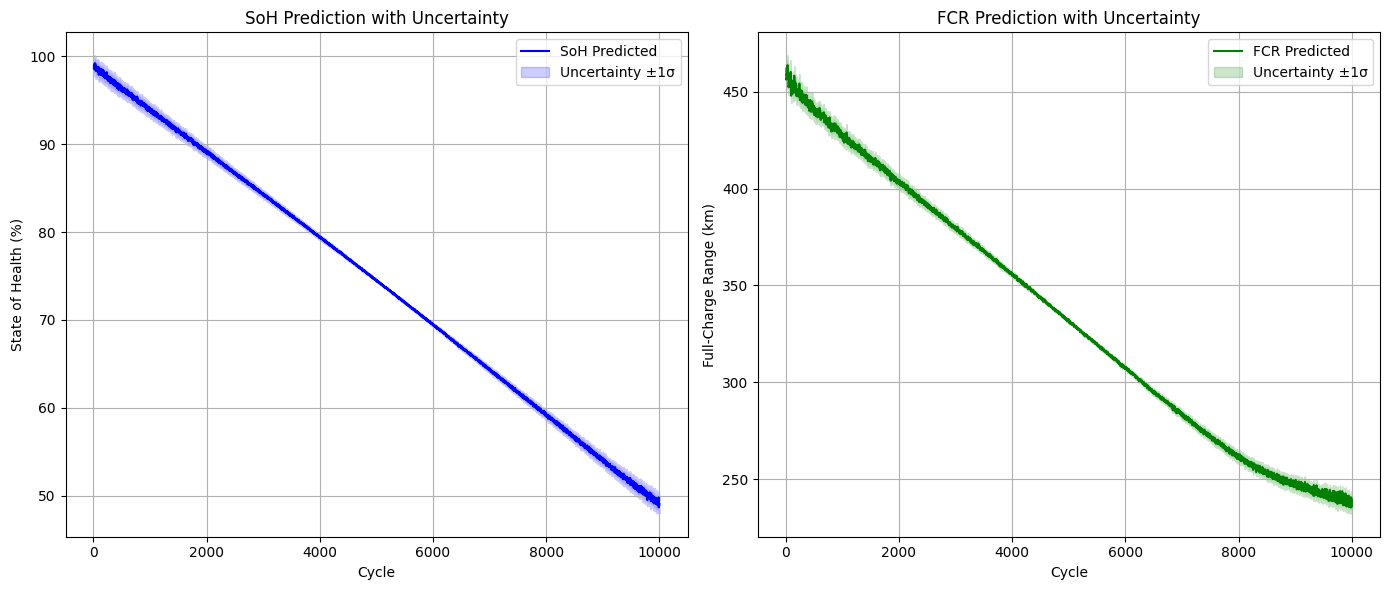

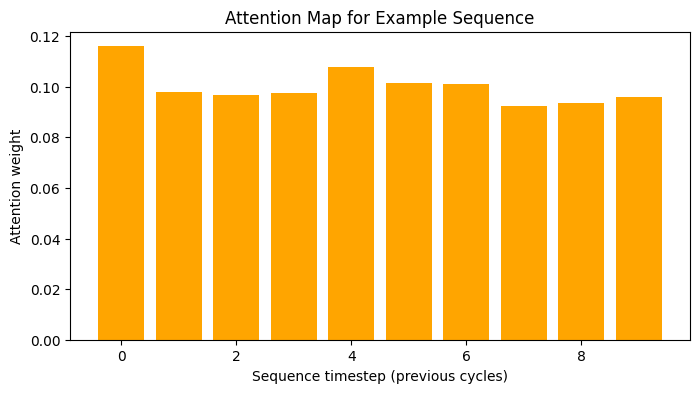

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14,6))

# SoH
plt.subplot(1,2,1)
plt.plot(cycles_unscaled_for_reporting, pred_df['SoH_pred_mean'], label='SoH Predicted', color='blue')
plt.fill_between(cycles_unscaled_for_reporting,
                 pred_df['SoH_pred_mean'] - pred_df['SoH_pred_std'],
                 pred_df['SoH_pred_mean'] + pred_df['SoH_pred_std'],
                 color='blue', alpha=0.2, label='Uncertainty ±1σ')
plt.xlabel('Cycle')
plt.ylabel('State of Health (%)')
plt.title('SoH Prediction with Uncertainty')
plt.legend()
plt.grid(True)

# FCR
plt.subplot(1,2,2)
plt.plot(cycles_unscaled_for_reporting, pred_df['FCR_pred_mean'], label='FCR Predicted', color='green')
plt.fill_between(cycles_unscaled_for_reporting,
                 pred_df['FCR_pred_mean'] - pred_df['FCR_pred_std'],
                 pred_df['FCR_pred_mean'] + pred_df['FCR_pred_std'],
                 color='green', alpha=0.2, label='Uncertainty ±1σ')
plt.xlabel('Cycle')
plt.ylabel('Full-Charge Range (km)')
plt.title('FCR Prediction with Uncertainty')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


model.eval()
example_idx = 2500
x_seq = features_tensor[example_idx-seq_len:example_idx].unsqueeze(0)

with torch.no_grad():
    out, attn_weights = model.bi_lstm(x_seq)
    attn_layer = model.attention
    context, attn_weights = attn_layer(out)

attn_weights = attn_weights.squeeze().cpu().numpy() 

plt.figure(figsize=(8,4))
plt.bar(range(seq_len), attn_weights, color='orange')
plt.xlabel('Sequence timestep (previous cycles)')
plt.ylabel('Attention weight')
plt.title('Attention Map for Example Sequence')
plt.show()